# Welter



Tuesday, June 21, 2016  

## Amplitude of variability and curve fitting

part 1

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## ASASSN Data from Subo Dong

In [3]:
#! head ../data/photometry/LkCa4.dat

In [4]:
import pandas as pd

The header contains 3 extraneous octothorpes "###".  Read the data just to get the columns.

In [5]:
fn = '../data/photometry/LkCa4.dat'
names = pd.read_csv(fn, delim_whitespace=True, nrows=0).columns[1:]
dat = pd.read_csv(fn, delim_whitespace=True, names=names, header=0, index_col=False)

In [6]:
dat.head()

,JD,HJD,UT_date,IMAGE,FWHM,Diff,Limit,mag,mag_err,counts,counts_err,flux(mJy),flux_err
0,2.455941e+06,2.455941e+06,2012-01-14.3965239,bb001648,2.35,-1.47,16.65,12.59,0.01,23612.98,187.30,35.148,0.317
1,2.455947e+06,2.455947e+06,2012-01-20.2912569,ba003166,2.31,-1.34,16.95,12.84,0.01,21207.88,160.02,28.058,0.289
2,2.455947e+06,2.455947e+06,2012-01-20.4472960,bb001935,2.29,-1.41,16.86,12.75,0.01,21677.08,164.28,30.534,0.267
3,2.455951e+06,2.455951e+06,2012-01-24.2801167,ba003621,2.18,-1.25,16.91,12.65,0.01,27518.04,181.12,33.527,0.292
4,2.455951e+06,2.455951e+06,2012-01-24.4488822,bb002695,2.38,-1.52,16.76,12.64,0.01,21692.91,162.36,33.839,0.321


## IGRINS Observation times

In [7]:
IG_OBS_date1 = 2457344.8609722229
IG_OBS_date2 = 2456990.790381945

**date1** is from the data I asked Greg Mace to acquire after discussions at the Seoul IGRINS workshop (Nov. 2015) with DTJ, G. Mace, and G. Herczeg.  
**date2** is data acquired previously that I have not used.

## Model the sparse lightcurve

In [8]:
inds = (dat.JD > 2457200) 

x = dat.JD[inds]
y = dat.mag[inds]
yerr = dat.mag_err[inds]

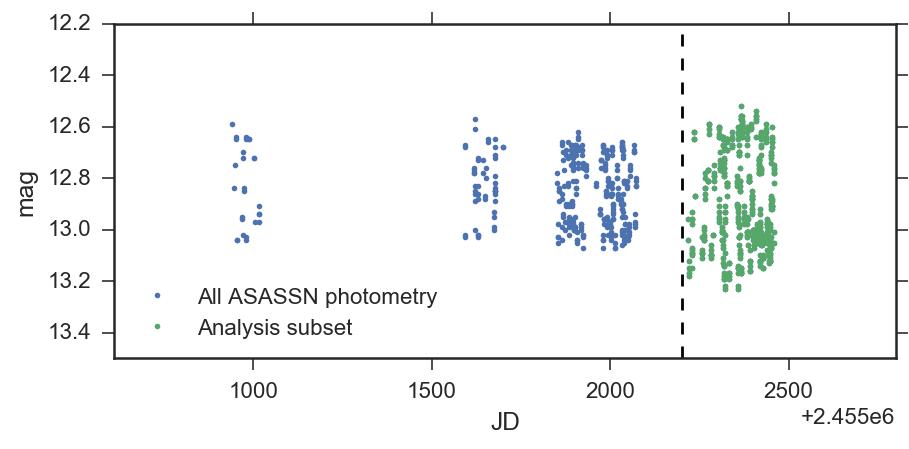

In [9]:
plt.figure(figsize=(7, 3))
plt.plot(dat.JD, dat.mag, '.', label='All ASASSN photometry')
plt.plot(x, y, '.', label='Analysis subset')
plt.ylim(13.5, 12.2)
plt.xlim(2455610, 2457800)
    
plt.vlines(2457200, 13.5, 12.2, linestyles='dashed')
    
plt.legend(loc='lower left')
plt.xlabel('JD')
plt.ylabel('mag');

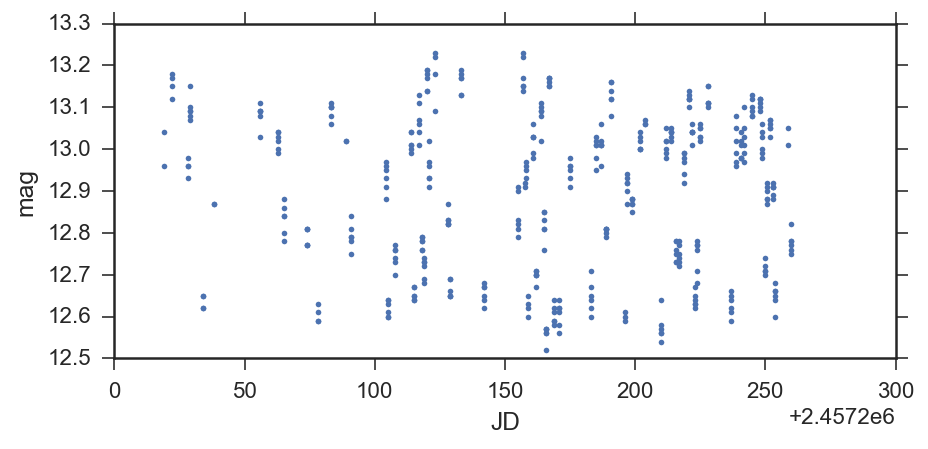

In [10]:
plt.figure(figsize=(7, 3))
plt.plot(x, y, '.', label='Analysis subset')
#plt.ylim(13.5, 12.2)
plt.xlim(2457200, 2457500)

plt.xlabel('JD')
plt.ylabel('mag');

## Dial in the period

In [11]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

In [12]:
light_curve = pd.DataFrame({"time":x, "flux":y, "err":y*0.03})

In [13]:
def run_periodograms(light_curve, P_range=[0.1, 10], samples=10000):
    '''Returns periodograms for hardcoded subset of K2 Cycle 2 lightcurve'''
    x = light_curve.time.values
    y = light_curve.flux.values
    yerr = light_curve.err.values
    
    periods = np.linspace(P_range[0], P_range[1], samples)

    omega = 2.00*np.pi/periods

    P_M = multiterm_periodogram(x, y, yerr, omega)
    P_LS = lomb_scargle(x, y, yerr, omega)
    return (periods, P_M, P_LS)

In [14]:
from scipy.signal import argrelmax

In [15]:
def top_N_periods(periods, lomb_scargle_power, n=5):
    '''Returns the top N Lomb-Scargle periods, given a vector of the periods and values'''
    
    # Get all the local maxima
    all_max_i = argrelmax(lomb_scargle_power)
    max_LS = lomb_scargle_power[all_max_i]
    max_periods = periods[all_max_i]
    
    # Sort by the Lomb-Scale power
    sort_i = np.argsort(max_LS)
    
    # Only keep the top N periods
    top_N_LS = max_LS[sort_i][::-1][0:n]
    top_N_pers = max_periods[sort_i][::-1][0:n]
    
    return top_N_pers, top_N_LS

In [16]:
def plot_LC_and_periodograms(lc, periods, P_M, P_LS):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.plot(lc.time, lc.flux, '.')
    plt.subplot(122)
    plt.step(periods, P_M, label='Multi-term periodogram')
    plt.step(periods, P_LS, label='Lomb Scargle')
    plt.legend()

In [17]:
lc = light_curve
periods, P_M, P_LS = run_periodograms(lc)

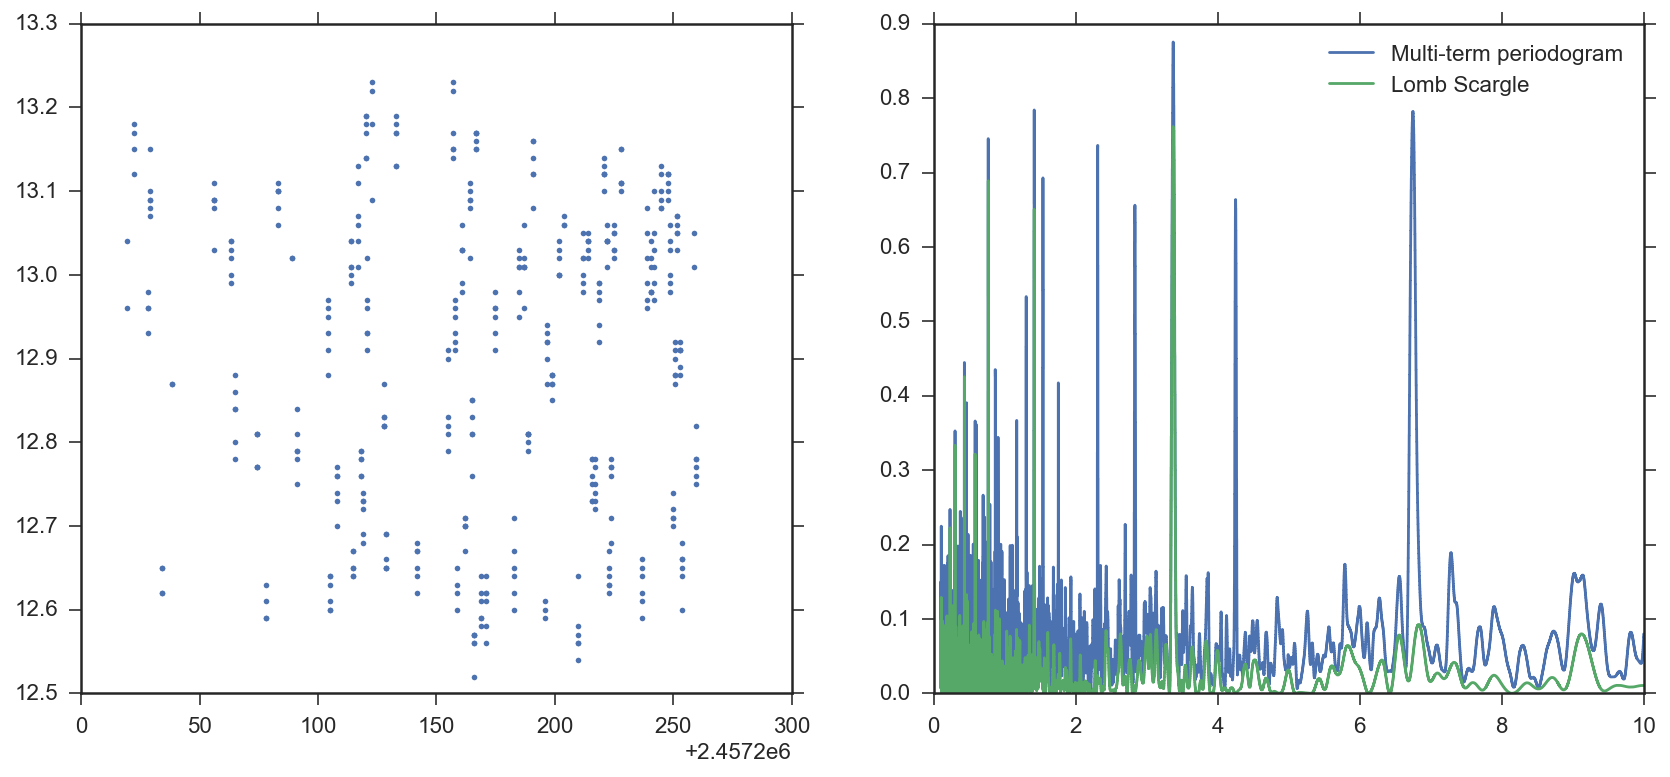

In [18]:
plot_LC_and_periodograms(lc, periods, P_M, P_LS)
plt.savefig('../results/periodgram_orig.pdf')

In [19]:
p_days_LS, X_sq_M = top_N_periods(periods, P_LS)
p_days_LS

array([ 3.37524752,  0.77029703,  1.41782178,  0.43465347,  0.3029703 ])

In [20]:
p_days_M, X_sq_LS = top_N_periods(periods, P_M)
p_days_M

array([ 3.37425743,  1.41782178,  6.75049505,  0.77029703,  2.31188119])

In [21]:
periods_fine, P_M_fine, P_LS_fine = run_periodograms(lc, P_range=[3.3, 3.45])

In [22]:
p_days_M, X_sq_LS = top_N_periods(periods_fine, P_M_fine, n=1)
P_fit = p_days_M[0]

In [23]:
print('The period is {:.4f} days'.format(P_fit))

The period is 3.3747 days


## Fit the amplitude

In [24]:
x, y, yerr = x.values, y.values, yerr.values

In [25]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

A = np.concatenate((np.expand_dims(sin_vector, 1),
                    np.expand_dims(cos_vector, 1),
                    np.vander(x, 8)), axis=1)

ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x[0], x[-1], 0.01)

A_dense = np.concatenate((np.expand_dims(np.sin(2.0*np.pi*x_dense/P_fit), 1),
                    np.expand_dims(np.cos(2.0*np.pi*x_dense/P_fit), 1),
                    np.vander(x_dense, 8)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

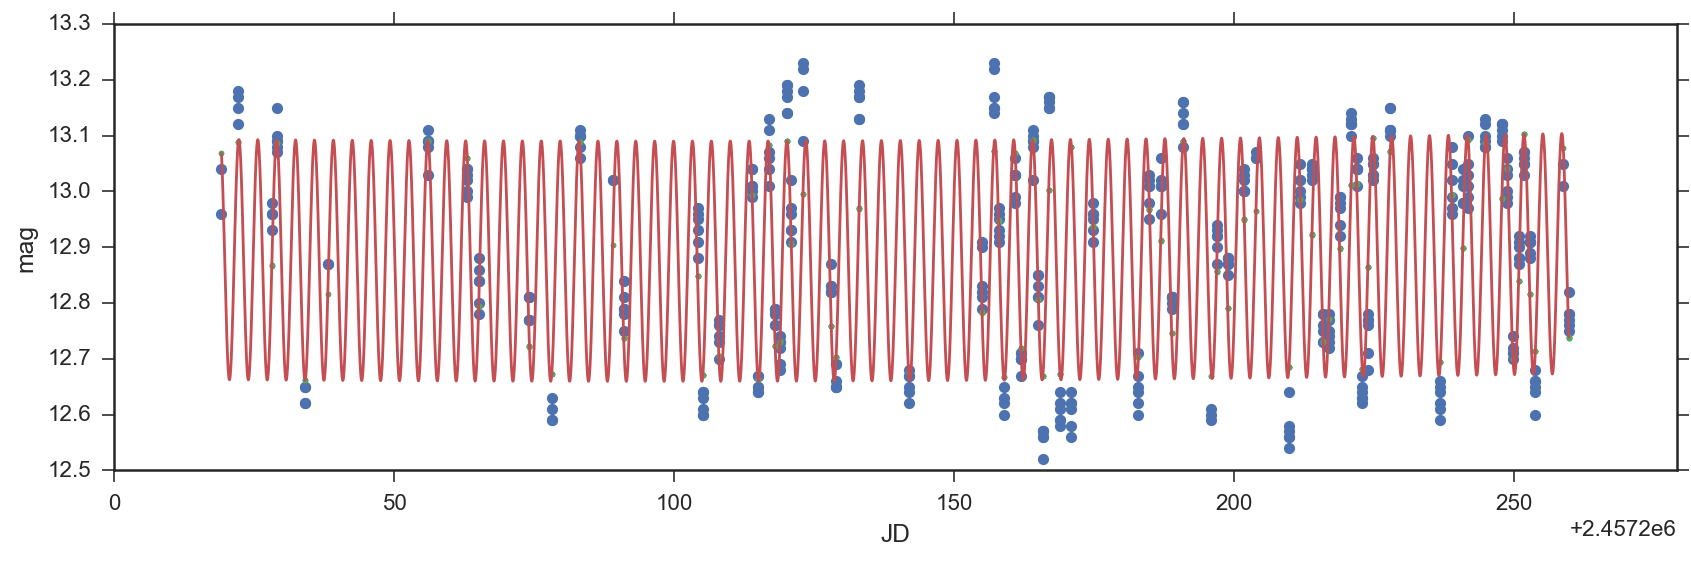

In [26]:
plt.figure(figsize=(14, 4))

plt.plot(x, y, 'o')
plt.plot(x, yfit, '.')
plt.plot(x_dense, yfit_dense)

plt.xlim(2457200, 2457319+160)
plt.xlabel('JD')
plt.ylabel('mag');

This is crap, we need a **multi-term fit** for the periodic component too.

Also, what's the deal with the **multiple observations within minutes** that show >0.1 mag scatter?  Is that astrophysical or instrumental?

## Convert near-contemporaneous observations into a single measurement and error

In [27]:
diff_df = pd.DataFrame({"a":lc.time[1:].values, "b":lc.time[0:-1].values, "c":lc.flux[1:].values})

In [28]:
diff_df['d'] = diff_df.a - diff_df.b

In [29]:
diff_df['d_min'] = diff_df.d * 24 * 60

Group observations by every 100 minutes chunks, or in other words observations separated by more than 100 minutes are probably separated by a few days.

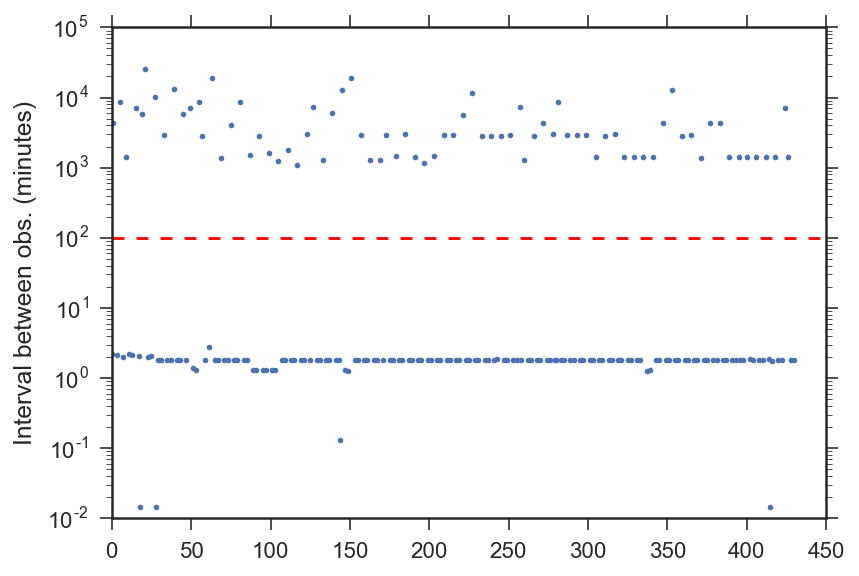

In [30]:
plt.plot(diff_df.d_min, '.')
plt.yscale('log')
plt.hlines(100, 0, 450, linestyles='dashed', colors='red')
plt.ylabel('Interval between obs. (minutes)');

In [31]:
diff_df['big_jump'] = diff_df.d_min > 100
diff_df['campaign'] = np.NAN
diff_df.campaign[diff_df.big_jump] = np.arange(diff_df.big_jump.sum())
diff_df.campaign.fillna(method='ffill', inplace=True)
diff_df.dropna(inplace=True)

(-0.5, 5.0)

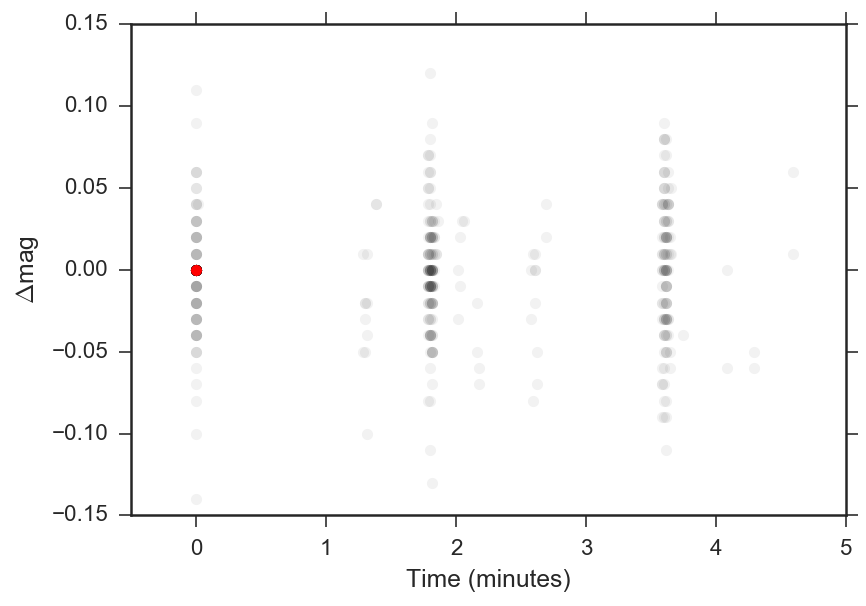

In [32]:
for name, group in diff_df.groupby('campaign'):
    plt.plot((group.a - group.a.values[0])*24.0*60, group.c-group.c.values[0], 'ko', alpha=0.05)
    #plt.plot((group.a - group.a.values[0])*24.0*60, group.c-group.c.values[0], 'r-', alpha=0.05)

plt.plot([0], [0], 'ro')
plt.xlabel('Time (minutes)')
plt.ylabel('$\Delta $mag')
plt.xlim(-0.5)

Looks like it's **just noise**.

In [33]:
grouped = diff_df.groupby('campaign')

means = grouped.aggregate({"a":np.mean, "c":np.mean})
stddevs = grouped.aggregate({"c":np.std})
n_obs = grouped.aggregate({"c":len})

aggregated_data = pd.concat([means.rename(columns={'a':'JD', 'c':'mean_mag'}), 
                             stddevs.rename(columns={'c':'stddev'}),
                             n_obs.rename(columns={'c':'n_obs'})],
                           axis=1)

aggregated_data.stddev[aggregated_data.stddev < 0.01] = 0.01

Much better.  Now we just have single values for ~5 minute chunks, with error bars for spread at that observation.

## Redo of periodogram with revised data

In [34]:
lc_refined = pd.DataFrame({"time":aggregated_data.JD.values,
                          "flux":aggregated_data.mean_mag.values,
                          "err":aggregated_data.stddev.values})

In [35]:
periods, P_M, P_LS = run_periodograms(lc_refined)

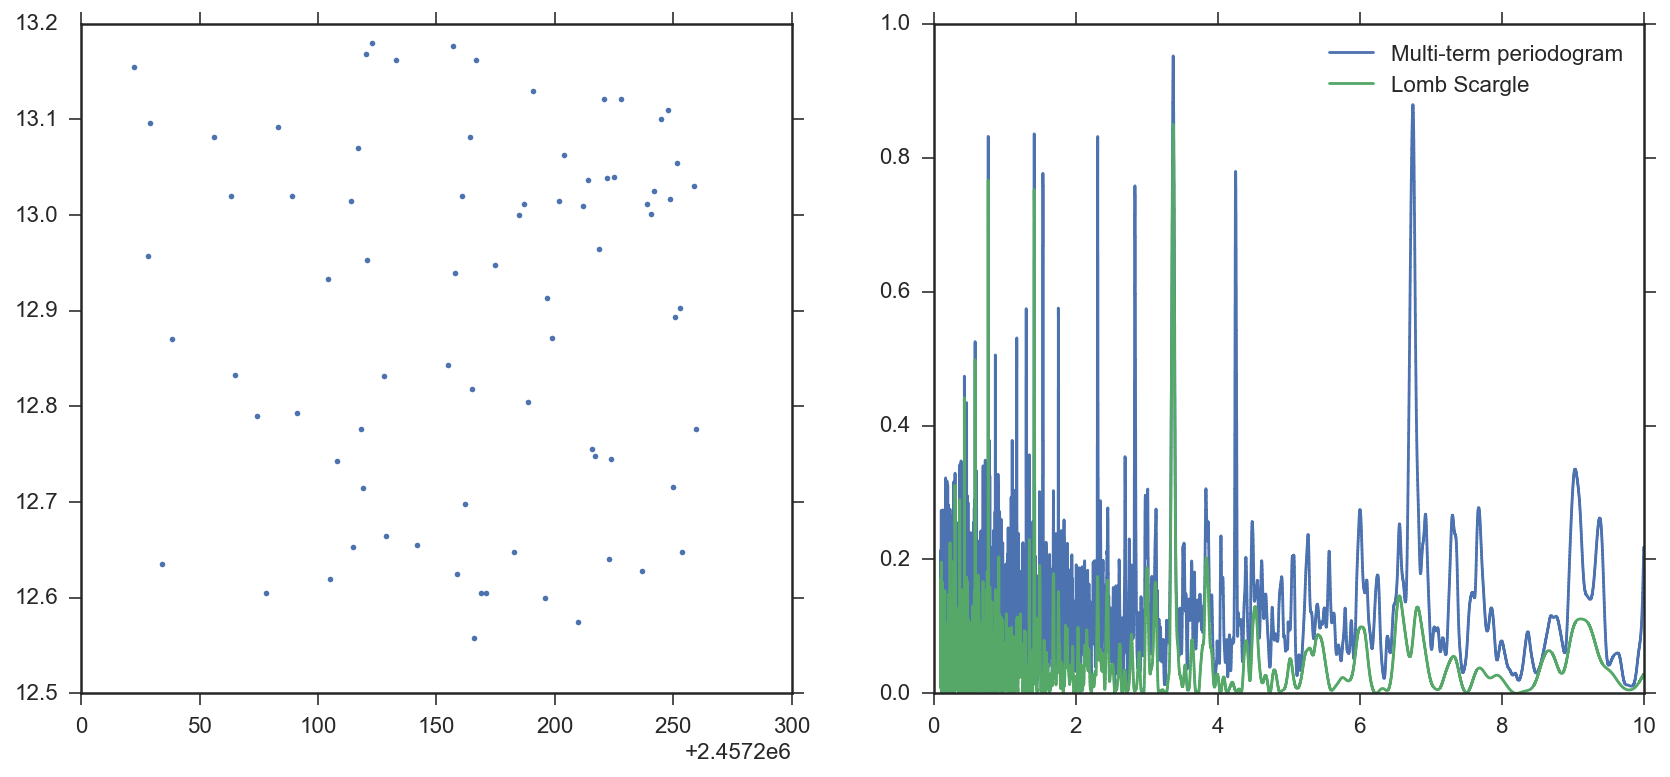

In [36]:
plot_LC_and_periodograms(lc_refined, periods, P_M, P_LS)
plt.savefig('../results/periodgram_refined.pdf')

In [37]:
periods, P_M, P_LS = run_periodograms(lc_refined, P_range=[3.36, 3.39], samples=30000)

In [38]:
P_fit = periods[np.argmax(P_M)]

In [39]:
P_fit

3.3749114970499017

Looks about the same as before.

## Do a multi-term fit to the phase-folded data

In [40]:
x = lc_refined.time.values
y = lc_refined.flux.values
yerr = lc_refined.err.values

In [41]:
import astroML.time_series

omega_best = 2.0*np.pi/P_fit
mtf = astroML.time_series.MultiTermFit(omega_best, 3)

In [42]:
phased = np.mod(lc_refined.time.values, P_fit)

In [43]:
mtf_fit = mtf.fit(phased, y, yerr)
phz, phz_yfit = mtf_fit.predict(100, adjust_offset=False)

(13.3, 12.5)

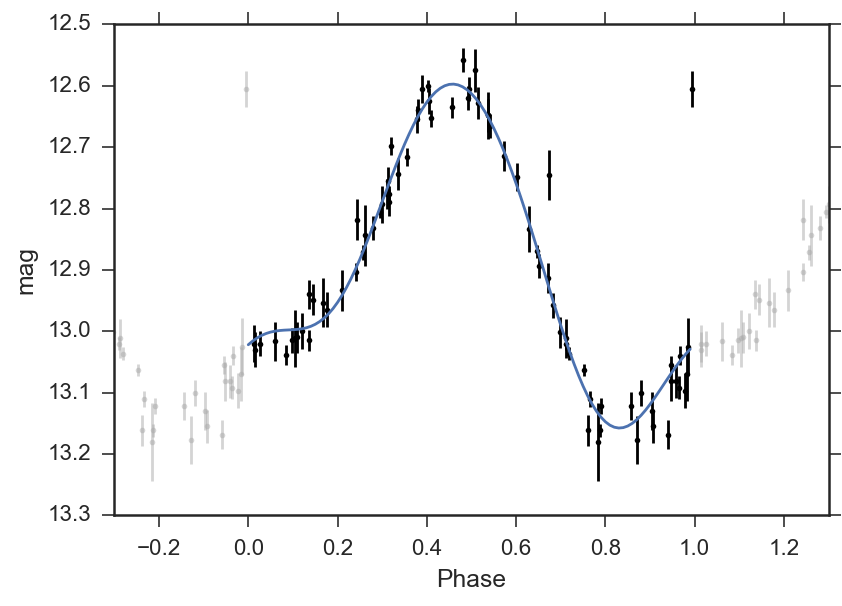

In [44]:
#plt.figure(figsize=(6,6))
    
plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('mag')

plt.plot(phz, phz_yfit)

plt.xlim(-0.3, 1.3)
plt.ylim(13.3, 12.5)

## Fit amplitude to aggregated data with errors, and a multiterm fit

In [45]:
M_max = 3 # Number of Fourier components
fourier_cs = np.arange(1,M_max)[:,np.newaxis]

sin_vector = np.sin(fourier_cs*2.0*np.pi*x/P_fit).T
cos_vector = np.cos(fourier_cs*2.0*np.pi*x/P_fit).T

A = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, 3)), axis=1)

In [46]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

yfit = np.matmul(mean_w, A.T)

x_dense = np.arange(x[0], x[-1], 0.01)

sin_vector_dense = np.sin(fourier_cs*2.0*np.pi*x_dense/P_fit).T
cos_vector_dense = np.cos(fourier_cs*2.0*np.pi*x_dense/P_fit).T

A_dense = np.concatenate((sin_vector_dense,
                    cos_vector_dense,
                    np.vander(x_dense, 3)), axis=1)

yfit_dense = np.matmul(mean_w, A_dense.T)

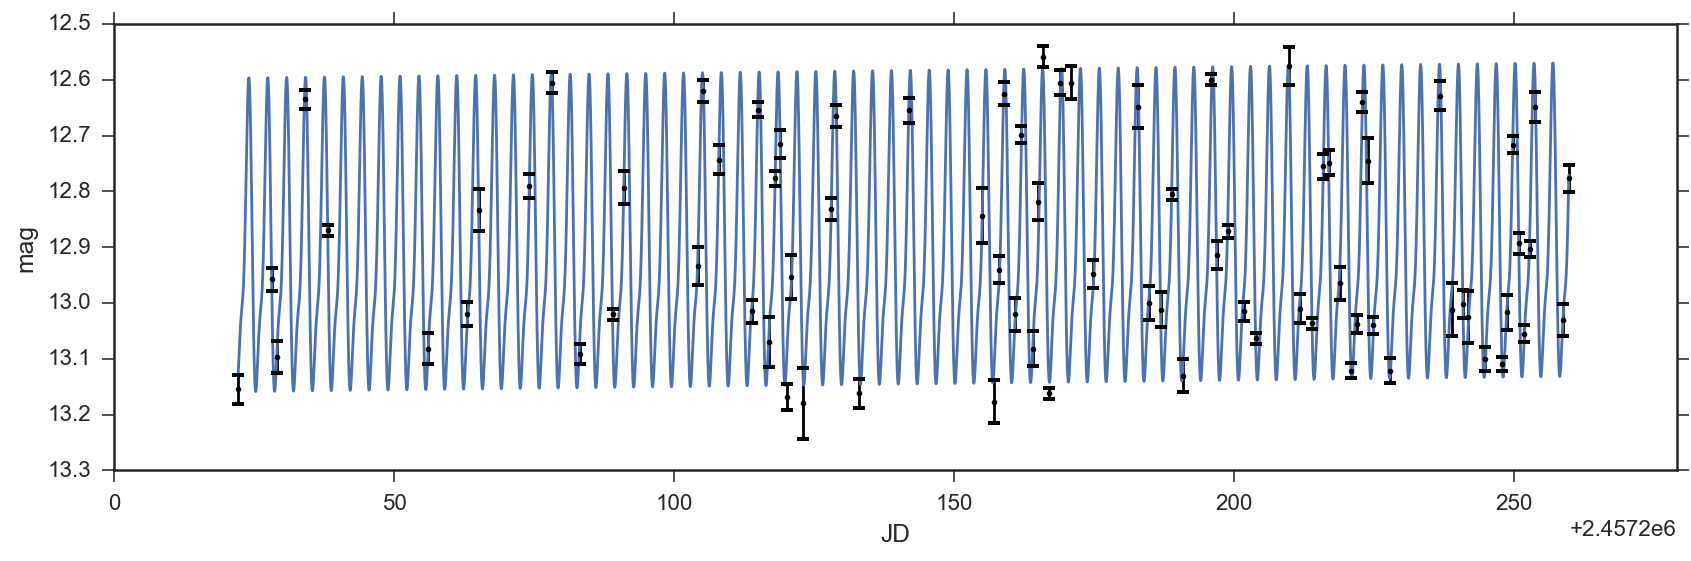

In [47]:
plt.figure(figsize=(14, 4))

#plt.plot(x, y, '.')
#plt.plot(x, yfit, 'o')
plt.plot(x_dense, yfit_dense)
#plt.plot(aggregated_data.JD, aggregated_data.mean_mag, 'ys')
plt.errorbar(x, y, yerr, fmt = 'k.', barsabove=True, capthick=2)

plt.xlim(2457200, 2457319+160)
plt.ylim(13.3, 12.5)
plt.xlabel('JD')
plt.ylabel('mag');

In [48]:
this_phase = np.mod(x, P_fit)/P_fit

In [51]:
IG_OBS_date1 = 2457344.8609722229
IG_OBS_date2 = 2456990.790381945
phased_IG = np.mod(IG_OBS_date1, P_fit)
phased_IG2 = np.mod(IG_OBS_date2, P_fit)

In [59]:
P_fit

3.3749114970499017

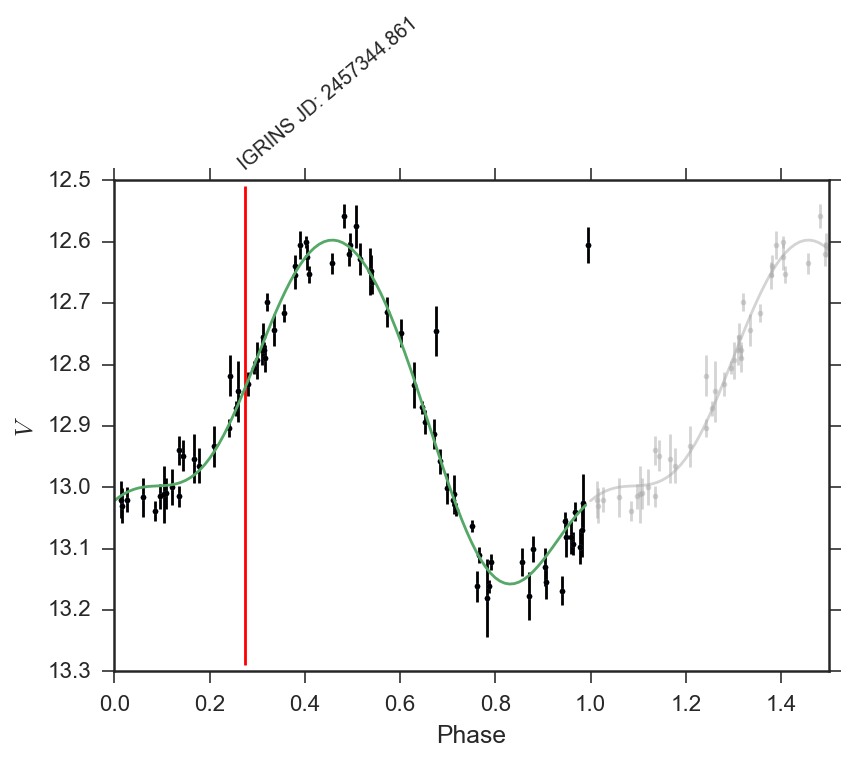

In [62]:
plt.plot(np.mod(x, P_fit)/P_fit, y, '.')

plt.errorbar(phased/P_fit, y, yerr, fmt='k.')
plt.errorbar(phased/P_fit+1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.errorbar(phased/P_fit-1.0, y, yerr, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('$V$')

plt.plot(phz, phz_yfit)
plt.plot(phz+1, phz_yfit, color='#AAAAAA', alpha=0.5)
plt.plot(phz-1, phz_yfit, color='#AAAAAA', alpha=0.5)

plt.vlines(phased_IG/P_fit, 12.51, 13.29, linestyles='solid', colors='red')
#plt.vlines(phased_IG2/P_fit, 12.51, 13.29, linestyles='dashed')

plt.text(phased_IG/P_fit-0.02, 12.49, 'IGRINS JD: {:.3f}'.format(IG_OBS_date1), rotation=40, 
        verticalalignment='bottom')

#plt.text(phased_IG2/P_fit-0.02, 12.49, 'IGRINS JD: {:.3f}'.format(IG_OBS_date2), rotation=40, 
#        verticalalignment='bottom')

plt.xlim(0.0, 1.5)
plt.ylim(13.3, 12.5)
plt.savefig('../document/figures/ASASSN_phase_fitted.pdf', bbox_inches="tight")

Wow, looks good!  You can even see some flares in there.

## Cross validation for complexity of de-trending *and* number $M$ of Fourier components

In [54]:
from sklearn import cross_validation

In [55]:
def lin_regress(A, y, yerr):
    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
    return mean_w

In [56]:
polys = np.arange(1, 8)
net_scores = np.zeros(len(polys))
n_folds = 10

In [57]:
j = 0
for n_poly in polys:


    X = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, n_poly)), axis=1)
    
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

In [58]:
%matplotlib inline

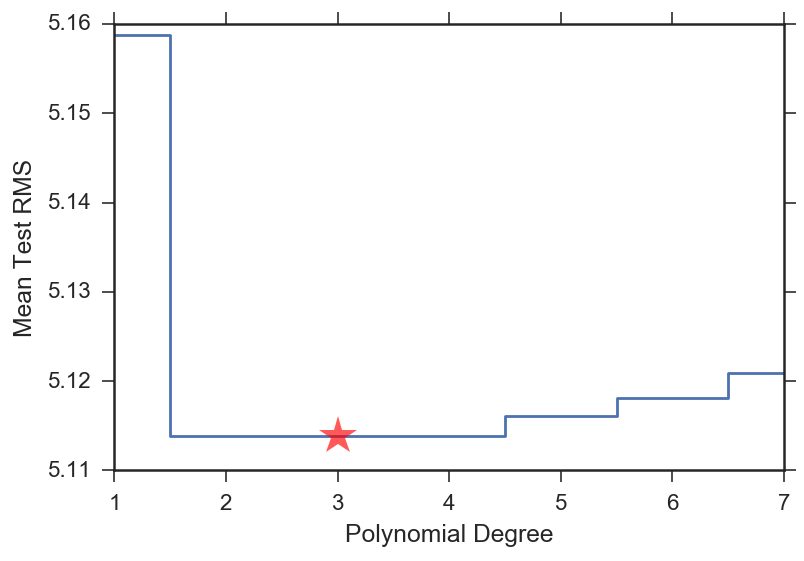

In [59]:
plt.step(polys, net_scores, where='mid')
plt.xlabel('Polynomial Degree')
plt.plot([polys[np.argmin(net_scores)]], [np.min(net_scores)], 'r*', ms=20, alpha=0.65)
plt.ylabel('Mean Test RMS')

It looks like it slightly prefers $3^{rd}$ order polynomial.  What about $M$, the number of Fourier components?

In [60]:
M_maxes = np.arange(1,14)

In [61]:
net_scores = np.zeros(len(M_maxes))

In [62]:
j = 0
for M_max in M_maxes:

    fourier_cs = np.arange(1,M_max)[:,np.newaxis]
    sin_vector = np.sin(fourier_cs*2.0*np.pi*x/P_fit).T
    cos_vector = np.cos(fourier_cs*2.0*np.pi*x/P_fit).T

    X = np.concatenate((sin_vector,
                    cos_vector,
                    np.vander(x, 3)), axis=1)
    
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

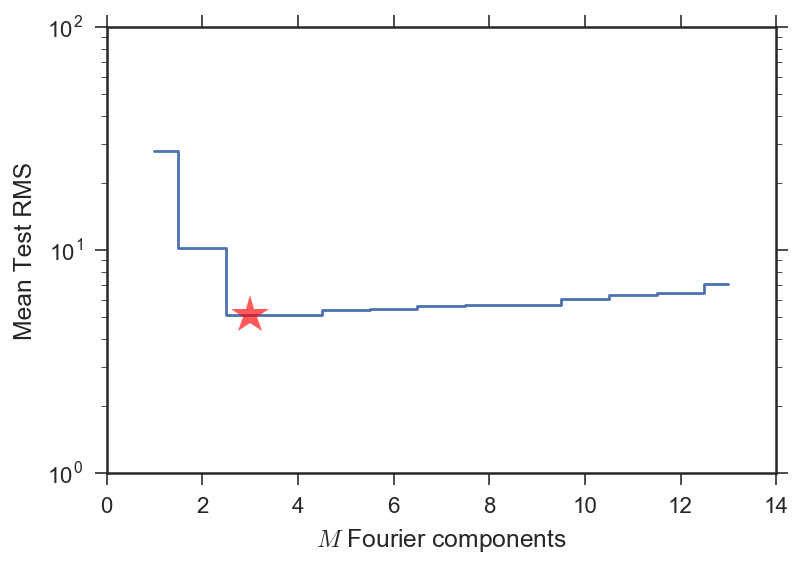

In [63]:
plt.step(M_maxes, net_scores, where='mid')
plt.xlabel('$M$ Fourier components')
plt.ylabel('Mean Test RMS')
plt.plot([M_maxes[np.argmin(net_scores)]], [np.min(net_scores)], 'r*', ms=20, alpha=0.65)
plt.yscale('log')

It looks like it slightly prefers $M=3$ Fourier components.

# The end.